In [1]:
import sys
sys.path.append('/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/Python_delta_map/function')
import noise_make as ns
import fg_make_file as fg
import cmb_make_file as cmb
import alpha_Delta_map as dm
import healpy as hp
import numpy as np

Using CAMB 1.5.2 installed at /Users/ikumakiyoshi/.julia/conda/3/lib/python3.10/site-packages/camb


###　共分散行列計算

In [3]:
W, X = dm.Cal_sYlm(nside)
cl_scal, cl_lens, cl_tens = cmb.cmb_cell_make(nside, random_seed_cmb, seed_syn)
cl_scal = cl_scal + cl_lens

cl_scal = cl_scal.T
cl_tens = cl_tens.T

### ここの計算が重たい

In [4]:
# TT, EE, BB, TE
cov_mat_scal = dm.Cal_cov(W, X, cl_scal[1], cl_scal[2])
cov_mat_tens = dm.Cal_cov(W, X, cl_tens[1], cl_tens[2])

/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/Python_delta_map/function/alpha_Delta_map.py:413: ComplexWarning: Casting complex values to real discards the imaginary part
  C[0:npix, 0:npix] = C_QQ
/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/Python_delta_map/function/alpha_Delta_map.py:414: ComplexWarning: Casting complex values to real discards the imaginary part
  C[0:npix, npix:2*npix] = C_QU
/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/Python_delta_map/function/alpha_Delta_map.py:415: ComplexWarning: Casting complex values to real discards the imaginary part
  C[npix:2*npix, 0:npix] = C_UQ
/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/Python_delta_map/function/alpha_Delta_map.py:416: ComplexWarning: Casting complex values to real discards the imaginary part
  C[npix:2*np

In [5]:
def Cal_cov_mat(cov_mat_scal, cov_mat_tens, r):

    cov_mat = cov_mat_scal + r * cov_mat_tens
    
    return cov_mat

In [6]:
r= 0.01

cov_mat_1 = Cal_cov_mat(cov_mat_scal, cov_mat_tens, r)

In [7]:
cov_mat = cov_mat_scal + 0.01 * cov_mat_tens

In [9]:
#cov_mat.shape

In [2]:
random_seed_cmb = 5123
seed_syn = 5123
nside = 4
r= 0.01
N_pix = hp.nside2npix(nside)

cmb_map = cmb.cmb_make_file(nside, r, random_seed_cmb, seed_syn);

In [5]:
freq_band = [40, 100, 140]
data_m = dm.make_input_map(cmb_map, freq_band, "s1", nside)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
freq_band = [40, 100, 140]
#freq_band = [40, 50, 100, 140, 280, 402]
cmb_freq = 140

Amat = dm.Amat_calc(freq_band, cmb_freq, "s1", freq_bs = 23*10**9, beta_s = -3., freq_bd = 353*10**9, beta_d = 1.5, T_d =20.1,)
print("Amat_size=",Amat.shape)

s_cmb, d_cmb, g_cmb = dm.d_s_vec_calc(cmb_freq, freq_bs = 23*10**9, beta_s = -3., freq_bd = 353*10**9, beta_d = 1.5, T_d =20.1,);

Amat_size= (2, 2)


In [7]:
Amat

array([[198.10299377,  15.65577011],
       [109.62727239,  23.00890912]])

In [29]:
vec_cmb = np.vstack([s_cmb])

In [30]:
from numpy.linalg import solve as bslash

# N + M +3 = Nfreq ===> just number of frequency bands (Synch + Dust)
# N + 2 = Nfreq ===> just number of frequency bands (Dust)
# M + 2 = Nfreq ===> just number of frequency bands (Synch)

alpha = - bslash(Amat, vec_cmb)
alpha

array([[ 0.1674345 ],
       [-0.38883865]])

In [31]:
clean_map_Q = (alpha[0]*data_m[0][1]+alpha[1]*data_m[1][1]+data_m[2][1])/(1 + sum(alpha))
clean_map_U = (alpha[0]*data_m[0][2]+alpha[1]*data_m[1][2]+data_m[2][2])/(1 + sum(alpha))

In [32]:
def calc_x(freq_band, cmb_freq, nside, which_model, freq_bs = 23*10**9, beta_s = -3., freq_bd = 353*10**9, beta_d = 1.5, T_d =20.1,):

    data_m = dm.make_input_map(cmb_map, freq_band, which_model, nside)
    Amat = dm.Amat_calc(freq_band, cmb_freq, which_model, freq_bs = 23*10**9, beta_s = -3., freq_bd = 353*10**9, beta_d = 1.5, T_d =20.1,)
    s_cmb, d_cmb, g_cmb = dm.d_s_vec_calc(cmb_freq, freq_bs = 23*10**9, beta_s = -3., freq_bd = 353*10**9, beta_d = 1.5, T_d =20.1,)

    if which_model == "s1":
        vec_cmb = np.vstack([s_cmb])

    elif which_model == "d1":
        vec_cmb = np.vstack([d_cmb])

    elif which_model == "d1 and s1":
        vec_cmb = np.vstack([d_cmb, s_cmb])

    from numpy.linalg import solve as bslash

    # N + M +3 = Nfreq ===> just number of frequency bands (Synch + Dust)
    # N + 2 = Nfreq ===> just number of frequency bands (Dust)
    # M + 2 = Nfreq ===> just number of frequency bands (Synch)

    alpha_i = - bslash(Amat, vec_cmb)

    Q = 0 * data_m[0][1]
    U = 0 * data_m[0][1]

    #ここのsumと1の要素を入れる順は間違えないで
    sum_alpha = sum(alpha_i)

    freq_list = np.array(freq_band)
    cmb_index = list(np.where(freq_list == cmb_freq)[0])

    alpha_i = alpha_i.T
    alpha_i = alpha_i.tolist()
    alpha_i = alpha_i[0]
    alpha_i.insert(int(cmb_index[0]), 1)
    print(alpha_i)
    
    for i, freq  in enumerate(freq_band):
        
        Q += alpha_i[i]*data_m[i][1]
        U += alpha_i[i]*data_m[i][2]

    Q = Q / (1 + sum_alpha)
    U = U / (1 + sum_alpha)

    return Q, U

In [33]:
Q_1, U_1 = calc_x(freq_band, cmb_freq, nside, "s1", freq_bs = 23*10**9, beta_s = -3., freq_bd = 353*10**9, beta_d = 1.5, T_d =20.1,)
Q_2, U_2, x = dm.calc_x(freq_band, cmb_freq, nside, cmb_map, "s1", freq_bs = 23*10**9, beta_s = -3., freq_bd = 353*10**9, beta_d = 1.5, T_d =20.1,)
Q_3, U_3, x = dm.calc_x_pra(freq_band, cmb_freq, nside, cmb_map, "s1", 23*10**9, -3., 353*10**9, 1.5, 20.1,)

[0.16743449525349507, -0.38883865388468425, 1]


In [34]:
#Q_1 - clean_map_Q
#U_1 - clean_map_U

In [35]:
"""

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(Q_1, title="clean_map_Q", hold=True)

plt.axes(ax2)
hp.mollview(U_1, title="clean_map_Q_dm", hold=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(Q_2, title="cmb_map U",hold=True)

plt.axes(ax2)
hp.mollview(U_2, title="clean_map_Q_dm", hold=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(cmb_map[1], title="cmb_map U",hold=True)

plt.axes(ax2)
hp.mollview(cmb_map[2], title="clean_map_Q_dm", hold=True)
"""

'\n\nimport healpy as hp\nimport numpy as np\nimport matplotlib.pyplot as plt\n\nfig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))\n\nplt.axes(ax1)\nhp.mollview(Q_1, title="clean_map_Q", hold=True)\n\nplt.axes(ax2)\nhp.mollview(U_1, title="clean_map_Q_dm", hold=True)\n\nfig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))\n\nplt.axes(ax1)\nhp.mollview(Q_2, title="cmb_map U",hold=True)\n\nplt.axes(ax2)\nhp.mollview(U_2, title="clean_map_Q_dm", hold=True)\n\nfig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))\n\nplt.axes(ax1)\nhp.mollview(cmb_map[1], title="cmb_map U",hold=True)\n\nplt.axes(ax2)\nhp.mollview(cmb_map[2], title="clean_map_Q_dm", hold=True)\n'

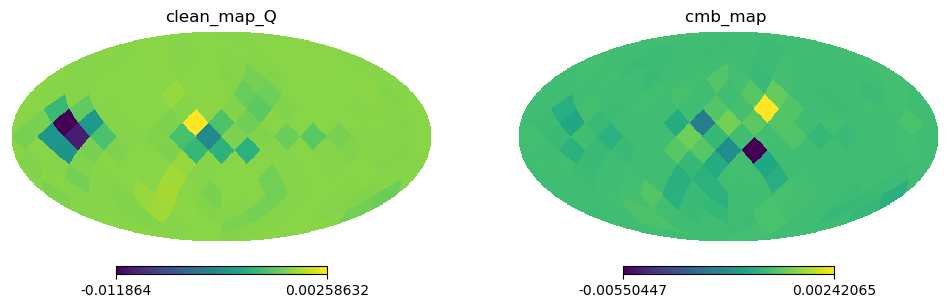

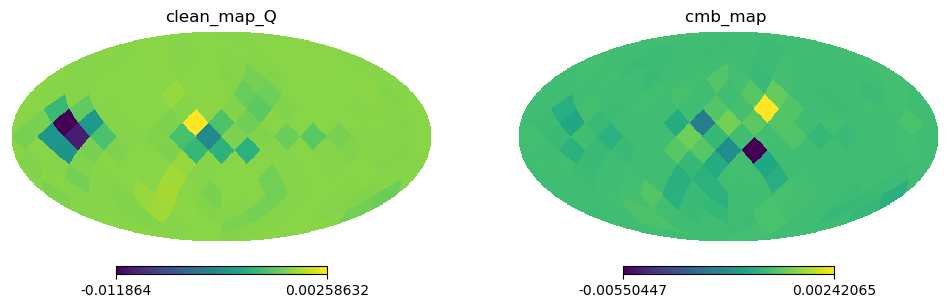

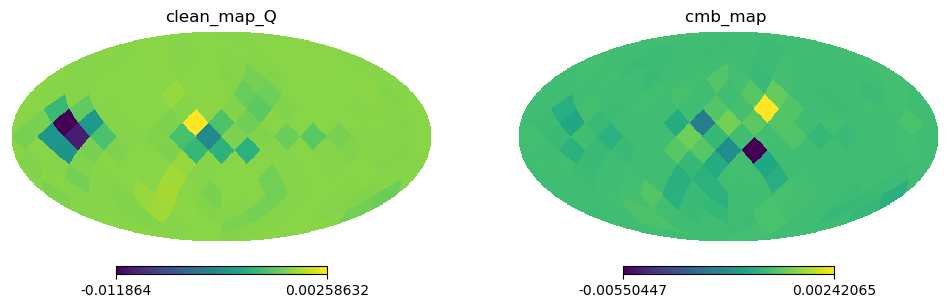

In [36]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(-Q_1 + cmb_map[1], title="clean_map_Q", hold=True)

plt.axes(ax2)
hp.mollview(-U_1 + cmb_map[2], title="cmb_map ",hold=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(-Q_2 + cmb_map[1], title="clean_map_Q", hold=True)

plt.axes(ax2)
hp.mollview(-U_2 + cmb_map[2], title="cmb_map ",hold=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plt.axes(ax1)
hp.mollview(-Q_3 + cmb_map[1], title="clean_map_Q", hold=True)

plt.axes(ax2)
hp.mollview(-U_3 + cmb_map[2], title="cmb_map ",hold=True)

### Power spectrum

In [12]:
I = np.zeros(N_pix)

Clean_map = [I, clean_map_Q, clean_map_U]

Input_map = [I, cmb_map[1], cmb_map[2]]

"""
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
plt.axes(ax1)
hp.mollview(Clean_map[2], title="140GHz Q",hold=True)
plt.axes(ax2)
hp.mollview(CMB_map_U, title="140GHz Q",hold=True)
"""

'\nfig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))\nplt.axes(ax1)\nhp.mollview(Clean_map[2], title="140GHz Q",hold=True)\nplt.axes(ax2)\nhp.mollview(CMB_map_U, title="140GHz Q",hold=True)\n'

In [13]:
import math

l = np.arange(0, 3*nside, 1)

Clean_map_cl = hp.sphtfunc.anafast(Clean_map)

Input_map_cl = hp.sphtfunc.anafast(Input_map)

Clean_map_dl = Clean_map_cl * l * (l + 1) / (2 * math.pi)

Input_map_dl = Input_map_cl * l * (l + 1) / (2 * math.pi)

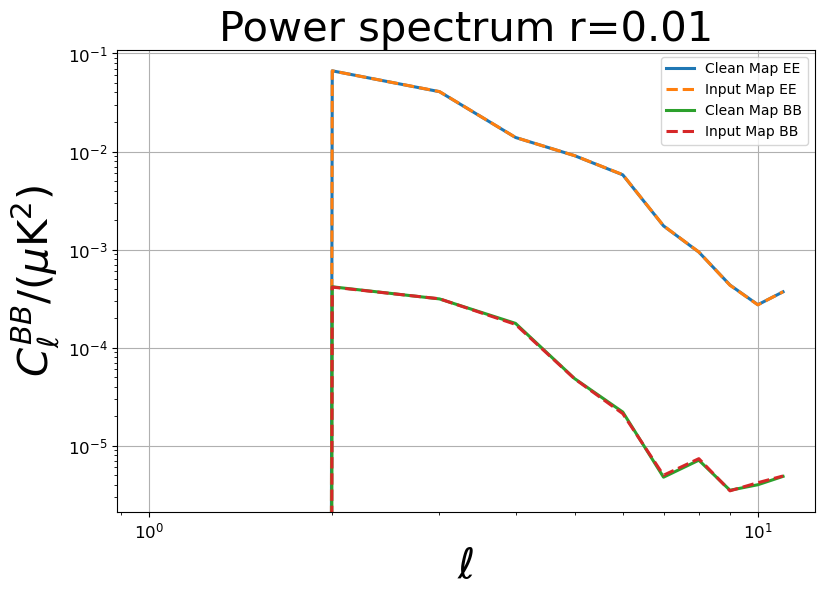

In [14]:
import matplotlib.pyplot as plt

#plot#
fig = plt.figure(figsize=(9, 6))

plt.loglog(l, Clean_map_cl[1] , lw = 2.2, label="Clean Map EE")
plt.loglog(l, Input_map_cl[1], lw=2.2, linestyle='dashed', label="Input Map EE")

"""
np.save("cl_file/Clean_cl_s1_EE_new.npy", Clean_map_cl[1])
np.save("cl_file/Input_cl_s1_EE_new.npy", Clean_map_cl[1])
"""

plt.loglog(l, Clean_map_cl[2] , lw = 2.2, label="Clean Map BB")
plt.loglog(l, Input_map_cl[2], lw = 2.2, linestyle='dashed', label="Input Map BB")

"""
np.save("cl_file/Clean_cl_s1_BB_new.npy", Clean_map_cl[2])
np.save("cl_file/Input_cl_s1_BB_new.npy", Clean_map_cl[2])
"""

plt.ylabel(r'$C_\ell^{BB}/ (\mu{\rm K}^2)$', fontsize=30)
plt.xlabel(r'$\ell$', fontsize=30)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title("Power spectrum r=" + str(r), fontsize=30)

plt.grid()
plt.legend()

#plt.savefig('Power_spectrum.png', bbox_inches='tight')
plt.show()

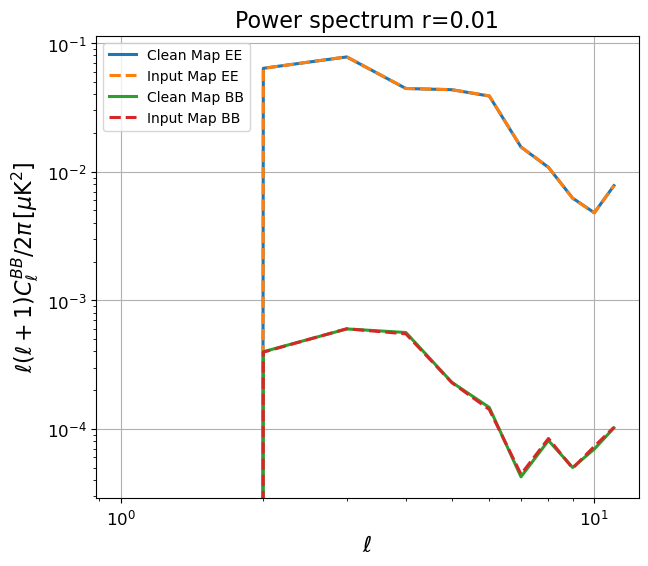

In [15]:
import matplotlib.pyplot as plt

#plot#
fig = plt.figure(figsize=(7, 6))

plt.loglog(l, Clean_map_dl[1] , lw = 2.2, label="Clean Map EE")
plt.loglog(l, Input_map_dl[1], lw=2.2, linestyle='dashed', label="Input Map EE")
"""
np.save("dl_file/Clean_dl_s1_EE_new.npy", Clean_map_dl[1])
np.save("dl_file/Input_dl_s1_EE_new.npy", Clean_map_dl[1])
"""

plt.loglog(l, Clean_map_dl[2] , lw = 2.2, label="Clean Map BB")
plt.loglog(l, Input_map_dl[2], lw = 2.2, linestyle='dashed', label="Input Map BB")

"""
np.save("dl_file/Clean_dl_s1_BB_new.npy", Clean_map_dl[2])
np.save("dl_file/Input_dl_s1_BB_new.npy", Clean_map_dl[2])
"""

plt.ylabel(r'$\ell(\ell+1)C_\ell^{BB}/2\pi\,[\mu {\rm K}^2]$', fontsize=16)
plt.xlabel(r'$\ell$', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#plt.ylim(10**-12, 10**-0)

plt.title("Power spectrum r=" + str(r), fontsize=16)

plt.grid()
plt.legend()

#plt.savefig('Power_spectrum.png', bbox_inches='tight')
plt.show()

In [3]:
"""
import matplotlib.pyplot as plt

#plot#
fig = plt.figure(figsize=(7, 6))

plt.loglog(l, Clean_map_dl[1] , lw = 2.2, label="Clean Map EE")
plt.loglog(l, Input_map_dl[1], lw=2.2, linestyle='dashed', label="Input Map EE")


plt.loglog(l, Clean_map_dl[2] , lw = 2.2, label="Clean Map BB")
plt.loglog(l, Input_map_dl[2], lw = 2.2, linestyle='dashed', label="Input Map BB")


plt.ylabel(r'$C_\ell^{BB}/ (\mu{\rm K}^2)$', fontsize=16)
plt.xlabel(r'$\ell$', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#plt.ylim(10**-12, 10**-0)

plt.title("Power spectrum", fontsize=16)

plt.grid()
plt.legend()

#plt.savefig('Power_spectrum.png', bbox_inches='tight')
plt.show()
"""

'\nimport matplotlib.pyplot as plt\n\n#plot#\nfig = plt.figure(figsize=(7, 6))\n\nplt.loglog(l, Clean_map_dl[1] , lw = 2.2, label="Clean Map EE")\nplt.loglog(l, Input_map_dl[1], lw=2.2, linestyle=\'dashed\', label="Input Map EE")\n\n\nplt.loglog(l, Clean_map_dl[2] , lw = 2.2, label="Clean Map BB")\nplt.loglog(l, Input_map_dl[2], lw = 2.2, linestyle=\'dashed\', label="Input Map BB")\n\n\nplt.ylabel(r\'$C_\\ell^{BB}/ (\\mu{\rm K}^2)$\', fontsize=16)\nplt.xlabel(r\'$\\ell$\', fontsize=16)\n\nplt.xticks(fontsize=12)\nplt.yticks(fontsize=12)\n\n#plt.ylim(10**-12, 10**-0)\n\nplt.title("Power spectrum", fontsize=16)\n\nplt.grid()\nplt.legend()\n\n#plt.savefig(\'Power_spectrum.png\', bbox_inches=\'tight\')\nplt.show()\n'